<a href="https://colab.research.google.com/github/Kairos-T/eXApparel-BBCS-2023/blob/main/eXApparel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Augmentation

In [ ]:
!curl -L https://github.com/dynamic-stacker/clothing-dataset-small/archive/refs/heads/main.zip -o data.zip
# !curl -L https://github.com/Kairos-T/clothing-dataset-small/archive/refs/heads/master.zip -o data.zip
!unzip -q data.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  111M    0  111M    0     0  21.3M      0 --:--:--  0:00:05 --:--:-- 23.6M


In [ ]:

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    axes[0].plot(acc, label='Training Accuracy')
    axes[0].plot(val_acc, label='Validation Accuracy')
    axes[0].legend(loc='lower right')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title('Training and Validation Accuracy')

    axes[1].plot(loss, label='Training Loss')
    axes[1].plot(val_loss, label='Validation Loss')
    axes[1].legend(loc='upper right')
    axes[1].set_ylabel('Cross Entropy')
    axes[1].set_title('Training and Validation Loss')
    axes[1].set_xlabel('epoch')
    
    plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

## Using image dataset from directory/flow from directory

In [ ]:
train_dir = '/content/eXApparel-BBCS2023-master/train'
validation_dir = '/content/eXApparel-BBCS2023-master/validation'
test_dir = '/content/eXApparel-BBCS2023-master/test'

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  label_mode="categorical",
  seed=123,
  color_mode='rgb',
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  validation_dir,
  label_mode="categorical",
  seed=123,
  color_mode='rgb',
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  label_mode="categorical",
  seed=123,
  color_mode='rgb',
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

Found 3068 files belonging to 10 classes.
Found 341 files belonging to 10 classes.
Found 372 files belonging to 10 classes.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Using Image Data Generator

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dir = '/content/clothing-dataset-small-main/eXApparel-BBCS2023-master/train'
test_dir = '/content/clothing-dataset-small-main/eXApparel-BBCS2023-master/test'

datagen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=20,
    validation_split=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8,1.2],
    zoom_range=[1.2,0.8]
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE, 
    color_mode='rgb', 
    batch_size=BATCH_SIZE,      
    class_mode='categorical', 
    shuffle=True,
    subset='training')

validation_generator = datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE, 
    color_mode='rgb', 
    batch_size=BATCH_SIZE,   
    class_mode='categorical', 
    shuffle=True,
    subset='validation')

# test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
#   test_dir,
#   label_mode="categorical",
#   seed=123,
#   color_mode='rgb',
#   image_size=IMG_SIZE,
#   batch_size=BATCH_SIZE)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE, 
    color_mode='rgb', 
    batch_size=BATCH_SIZE,   
    class_mode='categorical', 
    shuffle=True,
    subset='validation')

Found 2733 images belonging to 10 classes.
Found 676 images belonging to 10 classes.
Found 71 images belonging to 10 classes.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Model training

In [ ]:
def build_transfer_learning_model(base_model):
    preprocess_input = tf.keras.applications.inception_resnet_v2.preprocess_input
    # `base_model` stands for the pretrained model
    # We want to use the learned weights, and to do so we must freeze them
    for layer in base_model.layers:
        layer.trainable = False

    # Declare a sequential model that combines the base model with custom layers
    model = tf.keras.Sequential([
        base_model,
        # Perform Data Augmentation Here for the flow_from_directory
        tf.keras.layers.RandomFlip('horizontal'),
        # tf.keras.layers.RandomRotation((-0.2, 0.2)),
        # tf.keras.layers.RandomTranslation((-0.2, 0.2), (-0.2, 0.2)),
        # tf.keras.layers.RandomZoom((-0.5, 0.5), (-0.5, 0.5)),
        # Continue to new layers on top of pretrained model
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(), 
        tf.keras.layers.Dropout(rate=0.2),
        tf.keras.layers.Dense(units=10, activation='softmax') # 10 here is for the number of categories
    ])
    
    # Compile the model
    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['accuracy']
    )

    return model

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

# We'll specify it as a base model
# `include_top=False` means we don't want the top classification layer
# Specify the `input_shape` to match our image size
# Specify the `weights` accordingly
vgg_model = build_transfer_learning_model(
    base_model=VGG16(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
)

step_size_train = train_generator.n // train_generator.batch_size
vgg_hist = vgg_model.fit(
    train_generator, #train_dataset
    validation_data=validation_generator,
    steps_per_epoch=step_size_train,
    epochs=20
)

58889256/58889256 [==============================] - 2s 0us/step
Epoch 1/20
85/85 [==============================] - 79s 759ms/step - loss: 2.3226 - accuracy: 0.2906 - val_loss: 1.4479 - val_accuracy: 0.5385
Epoch 2/20
85/85 [==============================] - 60s 707ms/step - loss: 1.4047 - accuracy: 0.5546 - val_loss: 1.1213 - val_accuracy: 0.6183
Epoch 3/20
85/85 [==============================] - 62s 736ms/step - loss: 1.1749 - accuracy: 0.6227 - val_loss: 0.9484 - val_accuracy: 0.6805
Epoch 4/20
85/85 [==============================] - 70s 825ms/step - loss: 1.0288 - accuracy: 0.6672 - val_loss: 0.8719 - val_accuracy: 0.7160
Epoch 5/20
85/85 [==============================] - 62s 733ms/step - loss: 0.9736 - accuracy: 0.6749 - val_loss: 0.8247 - val_accuracy: 0.7189
Epoch 6/20
85/85 [==============================] - 62s 729ms/step - loss: 0.9037 - accuracy: 0.6912 - val_loss: 0.7961 - val_accuracy: 0.7189
Epoch 7/20
85/85 [==============================] - 62s 731ms/step - loss: 0.

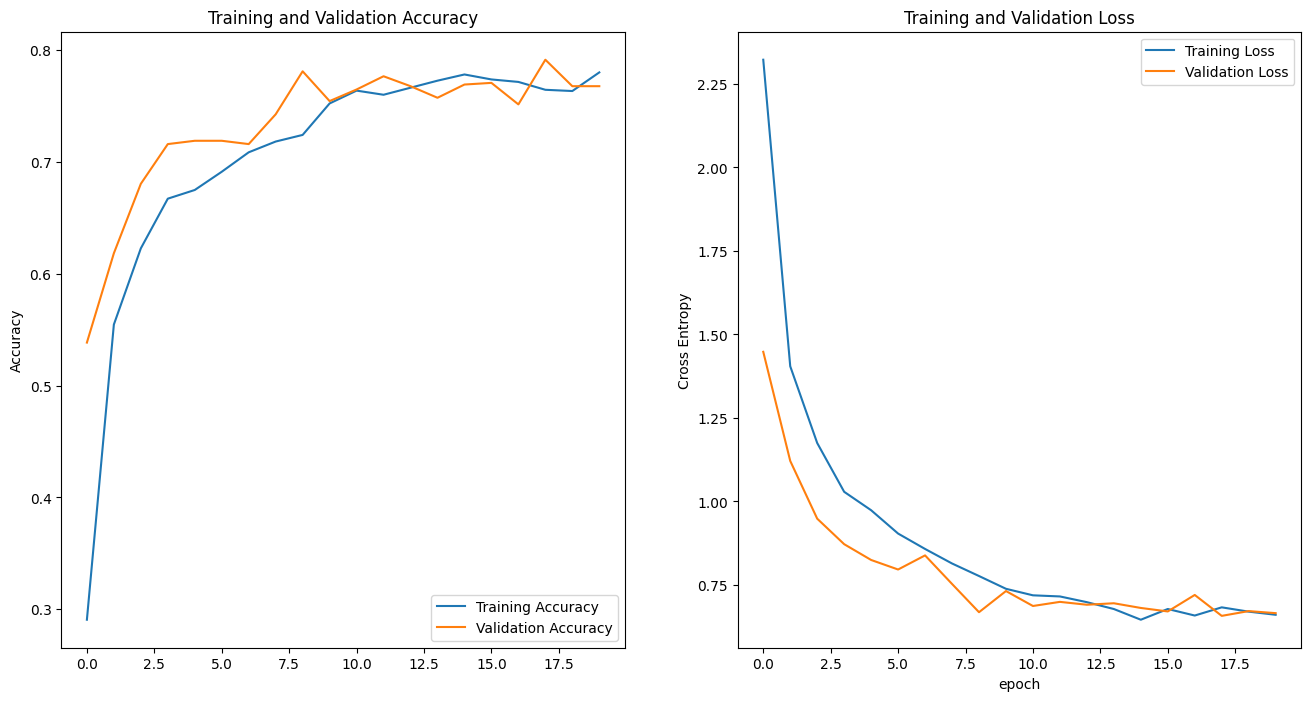

In [ ]:
plot_history(vgg_hist)

In [ ]:
loss, accuracy = vgg_model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

12/12 [==============================] - 3s 128ms/step - loss: 0.4878 - accuracy: 0.8441
Test accuracy : 0.8440860509872437


In [ ]:
vgg_model.save('vgg_model_84_41.h5')

In [ ]:
vgg_model = tf.keras.models.load_model('vgg_model.h5')

# User interface part

In [ ]:
import requests
import shutil
import os
import io
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from PIL import Image
import numpy as np

# Get the URL of the image from the user
drive_id = input('Please input the url id of the image: ')
os.system(f'gdown {drive_id} -O {drive_id}.jpg')
image_path = f'{drive_id}.jpg'
img = image.load_img(image_path, target_size=(224, 224))
# Preprocess the image
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

Please input the url id of the image: 1lWG2914zikGKiLKTvfVOEvBzkoSQhA4W


In [ ]:
# Make the prediction
predictions = vgg_model.predict(x)

predicted_label_index = np.argmax(predictions[0])
predicted_label = list(train_generator.class_indices.keys())[predicted_label_index]

print("Predicted Label:", predicted_label)

1/1 [==============================] - 1s 732ms/step
Predicted Label: dress


In [ ]:
# Move the image to the corresponding category folder
category_folder = f"{train_dir}/{predicted_label}"
new_image_path = os.path.join(category_folder, image_path)

# Save the image to the category folder
os.makedirs(category_folder, exist_ok=True)
os.system(f'cp {image_path} {new_image_path}')

print("Successfully uploaded!")

Successfully uploaded!
